# T1D Menstrual Cycle Synthetic Data Analysis

Interactive notebook for analyzing FHIR QuestionnaireResponse synthetic data.

## Overview
This notebook loads and analyzes synthetic data from the `output/` directory, validating the research hypothesis (HYP-MC-01) that women with T1D show measurable glucose and insulin changes during the luteal phase.

In [2]:
import json
import glob
from pathlib import Path
from datetime import datetime, timedelta
from typing import Dict, List, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

## 1. Data Loading

Load all FHIR QuestionnaireResponse JSON files from the output directory.

In [3]:
def load_questionnaire_responses(output_dir: str = "output/") -> List[Dict[str, Any]]:
    """Load all QuestionnaireResponse JSON files from output directory."""
    response_files = glob.glob(f"{output_dir}response-*.json")
    responses = []
    
    for file_path in sorted(response_files):
        with open(file_path, 'r') as f:
            responses.append(json.load(f))
    
    return responses

responses = load_questionnaire_responses()
print(f"Loaded {len(responses)} questionnaire responses")

Loaded 187 questionnaire responses


## 2. Data Transformation

Convert FHIR QuestionnaireResponse resources to a pandas DataFrame for analysis.

In [4]:
def extract_answer(item: Dict) -> Any:
    """Extract answer value from FHIR item."""
    if not item.get('answer'):
        return None
    
    answer = item['answer'][0]
    if 'valueInteger' in answer:
        return answer['valueInteger']
    elif 'valueDecimal' in answer:
        return answer['valueDecimal']
    elif 'valueString' in answer:
        return answer['valueString']
    elif 'valueDate' in answer:
        return answer['valueDate']
    return None

def extract_symptoms(item: Dict) -> List[str]:
    """Extract all symptom values from repeating choice item."""
    if not item.get('answer'):
        return []
    return [ans.get('valueString', '') for ans in item['answer']]

def calculate_cycle_phase(lmp_date: str, survey_date: str) -> str:
    """Calculate menstrual cycle phase based on LMP and survey date."""
    lmp = datetime.fromisoformat(lmp_date)
    survey = datetime.fromisoformat(survey_date.split('T')[0])
    days_since_lmp = (survey - lmp).days
    
    # Follicular: days 1-14, Luteal: days 15-28
    return 'Follicular' if days_since_lmp <= 14 else 'Luteal'

def responses_to_dataframe(responses: List[Dict]) -> pd.DataFrame:
    """Convert QuestionnaireResponse list to pandas DataFrame."""
    records = []
    
    for resp in responses:
        record = {
            'patient_id': resp['id'],
            'authored': resp['authored']
        }
        
        # Extract answers by linkId
        items_by_link = {item['linkId']: item for item in resp['item']}
        
        record['age'] = extract_answer(items_by_link.get('1'))
        record['years_since_diagnosis'] = extract_answer(items_by_link.get('2'))
        record['insulin_delivery'] = extract_answer(items_by_link.get('3'))
        record['lmp_date'] = extract_answer(items_by_link.get('4'))
        record['cycle_regularity'] = extract_answer(items_by_link.get('5'))
        record['basal_insulin'] = extract_answer(items_by_link.get('6'))
        record['nighttime_glucose'] = extract_answer(items_by_link.get('7'))
        record['sleep_awakenings'] = extract_answer(items_by_link.get('8'))
        record['symptoms'] = extract_symptoms(items_by_link.get('9'))
        record['subjective_text'] = extract_answer(items_by_link.get('10'))
        
        # Calculate cycle phase
        if record['lmp_date']:
            record['cycle_phase'] = calculate_cycle_phase(record['lmp_date'], record['authored'])
        
        # Parse symptoms into binary flags
        symptoms = record['symptoms']
        record['has_night_sweats'] = 'Night sweats' in symptoms
        record['has_dizziness'] = 'Dizziness' in symptoms
        record['has_palpitations'] = 'Palpitations' in symptoms
        record['has_fatigue'] = 'Weakness/Fatigue' in symptoms
        record['symptom_count'] = len(symptoms)
        
        records.append(record)
    
    return pd.DataFrame(records)

df = responses_to_dataframe(responses)
print(f"DataFrame shape: {df.shape}")
df.head()

DataFrame shape: (187, 18)


,patient_id,authored,age,years_since_diagnosis,insulin_delivery,lmp_date,cycle_regularity,basal_insulin,nighttime_glucose,sleep_awakenings,symptoms,subjective_text,cycle_phase,has_night_sweats,has_dizziness,has_palpitations,has_fatigue,symptom_count
0,response-patient-0001,2025-09-29T23:16:37.074022+02:00,42,3,Insulin Pump,2025-06-29,Somewhat regular,15.9,132.9,2,[Night sweats],My glucose levels tend to be higher during cer...,Luteal,True,False,False,False,1
1,response-patient-0002,2025-09-29T23:16:37.074825+02:00,26,2,Insulin Pump,2025-09-12,Somewhat regular,10.7,116.4,1,[],My glucose levels tend to be higher during cer...,Luteal,False,False,False,False,0
2,response-patient-0003,2025-09-29T23:16:37.075360+02:00,27,10,Insulin Pump,2025-08-23,Somewhat regular,14.4,168.3,2,[],My glucose levels tend to be higher during cer...,Luteal,False,False,False,False,0
3,response-patient-0004,2025-09-29T23:16:37.075868+02:00,34,22,Multiple Daily Injections,2025-07-04,Somewhat regular,12.9,107.4,0,[],My glucose levels tend to be higher during cer...,Luteal,False,False,False,False,0
4,response-patient-0005,2025-09-29T23:16:37.076357+02:00,22,3,Multiple Daily Injections,2025-07-09,Very regular (predictable),12.9,152.6,0,[],My glucose levels tend to be higher during cer...,Luteal,False,False,False,False,0


## 3. Cohort Summary Statistics

In [5]:
print("=== COHORT DEMOGRAPHICS ===")
print(f"Total responses: {len(df)}")
print(f"\nAge: {df['age'].mean():.1f} ± {df['age'].std():.1f} years (range: {df['age'].min()}-{df['age'].max()})")
print(f"Years since T1D diagnosis: {df['years_since_diagnosis'].mean():.1f} ± {df['years_since_diagnosis'].std():.1f} years")

print("\n=== INSULIN DELIVERY METHOD ===")
print(df['insulin_delivery'].value_counts())
print(f"Pump ratio: {(df['insulin_delivery'] == 'Insulin Pump').mean():.1%}")

print("\n=== CYCLE REGULARITY ===")
print(df['cycle_regularity'].value_counts())

print("\n=== CYCLE PHASE DISTRIBUTION ===")
print(df['cycle_phase'].value_counts())

=== COHORT DEMOGRAPHICS ===
Total responses: 187

Age: 31.6 ± 7.2 years (range: 18-45)
Years since T1D diagnosis: 12.1 ± 7.6 years

=== INSULIN DELIVERY METHOD ===
insulin_delivery
Insulin Pump                 124
Multiple Daily Injections     63
Name: count, dtype: int64
Pump ratio: 66.3%

=== CYCLE REGULARITY ===
cycle_regularity
Very regular (predictable)    115
Somewhat regular               49
Irregular                      23
Name: count, dtype: int64

=== CYCLE PHASE DISTRIBUTION ===
cycle_phase
Luteal        177
Follicular     10
Name: count, dtype: int64


## 4. Primary Hypothesis Testing: Luteal Phase Effects

Test whether luteal phase shows increased glucose, insulin, and symptoms compared to follicular phase.

In [6]:
# Group by cycle phase
follicular = df[df['cycle_phase'] == 'Follicular']
luteal = df[df['cycle_phase'] == 'Luteal']

print("=== FOLLICULAR PHASE (Baseline) ===")
print(f"N = {len(follicular)}")
print(f"Mean nighttime glucose: {follicular['nighttime_glucose'].mean():.1f} ± {follicular['nighttime_glucose'].std():.1f} mg/dL")
print(f"Mean basal insulin: {follicular['basal_insulin'].mean():.1f} ± {follicular['basal_insulin'].std():.1f} units")
print(f"Mean sleep awakenings: {follicular['sleep_awakenings'].mean():.2f} ± {follicular['sleep_awakenings'].std():.2f}")
print(f"Night sweats: {follicular['has_night_sweats'].mean():.1%}")
print(f"Dizziness: {follicular['has_dizziness'].mean():.1%}")
print(f"Palpitations: {follicular['has_palpitations'].mean():.1%}")

print("\n=== LUTEAL PHASE ===")
print(f"N = {len(luteal)}")
print(f"Mean nighttime glucose: {luteal['nighttime_glucose'].mean():.1f} ± {luteal['nighttime_glucose'].std():.1f} mg/dL")
print(f"Mean basal insulin: {luteal['basal_insulin'].mean():.1f} ± {luteal['basal_insulin'].std():.1f} units")
print(f"Mean sleep awakenings: {luteal['sleep_awakenings'].mean():.2f} ± {luteal['sleep_awakenings'].std():.2f}")
print(f"Night sweats: {luteal['has_night_sweats'].mean():.1%}")
print(f"Dizziness: {luteal['has_dizziness'].mean():.1%}")
print(f"Palpitations: {luteal['has_palpitations'].mean():.1%}")

print("\n=== STATISTICAL TESTS ===")
# T-tests
glucose_ttest = stats.ttest_ind(follicular['nighttime_glucose'], luteal['nighttime_glucose'])
insulin_ttest = stats.ttest_ind(follicular['basal_insulin'], luteal['basal_insulin'])
awakenings_ttest = stats.ttest_ind(follicular['sleep_awakenings'], luteal['sleep_awakenings'])

print(f"Nighttime glucose: t={glucose_ttest.statistic:.2f}, p={glucose_ttest.pvalue:.4f}")
print(f"Basal insulin: t={insulin_ttest.statistic:.2f}, p={insulin_ttest.pvalue:.4f}")
print(f"Sleep awakenings: t={awakenings_ttest.statistic:.2f}, p={awakenings_ttest.pvalue:.4f}")

print("\n=== EFFECT SIZES ===")
glucose_diff = luteal['nighttime_glucose'].mean() - follicular['nighttime_glucose'].mean()
insulin_diff = luteal['basal_insulin'].mean() - follicular['basal_insulin'].mean()
insulin_pct = (insulin_diff / follicular['basal_insulin'].mean()) * 100

print(f"Glucose increase (luteal): {glucose_diff:+.1f} mg/dL")
print(f"Insulin increase (luteal): {insulin_diff:+.1f} units ({insulin_pct:+.1f}%)")

=== FOLLICULAR PHASE (Baseline) ===
N = 10
Mean nighttime glucose: 124.6 ± 19.8 mg/dL
Mean basal insulin: 12.6 ± 2.7 units
Mean sleep awakenings: 0.80 ± 0.63
Night sweats: 10.0%
Dizziness: 10.0%
Palpitations: 10.0%

=== LUTEAL PHASE ===
N = 177
Mean nighttime glucose: 120.0 ± 20.4 mg/dL
Mean basal insulin: 14.2 ± 3.6 units
Mean sleep awakenings: 1.05 ± 0.72
Night sweats: 18.6%
Dizziness: 4.5%
Palpitations: 6.8%

=== STATISTICAL TESTS ===
Nighttime glucose: t=0.70, p=0.4822
Basal insulin: t=-1.40, p=0.1626
Sleep awakenings: t=-1.08, p=0.2807

=== EFFECT SIZES ===
Glucose increase (luteal): -4.7 mg/dL
Insulin increase (luteal): +1.6 units (+13.1%)


## 5. Visualizations

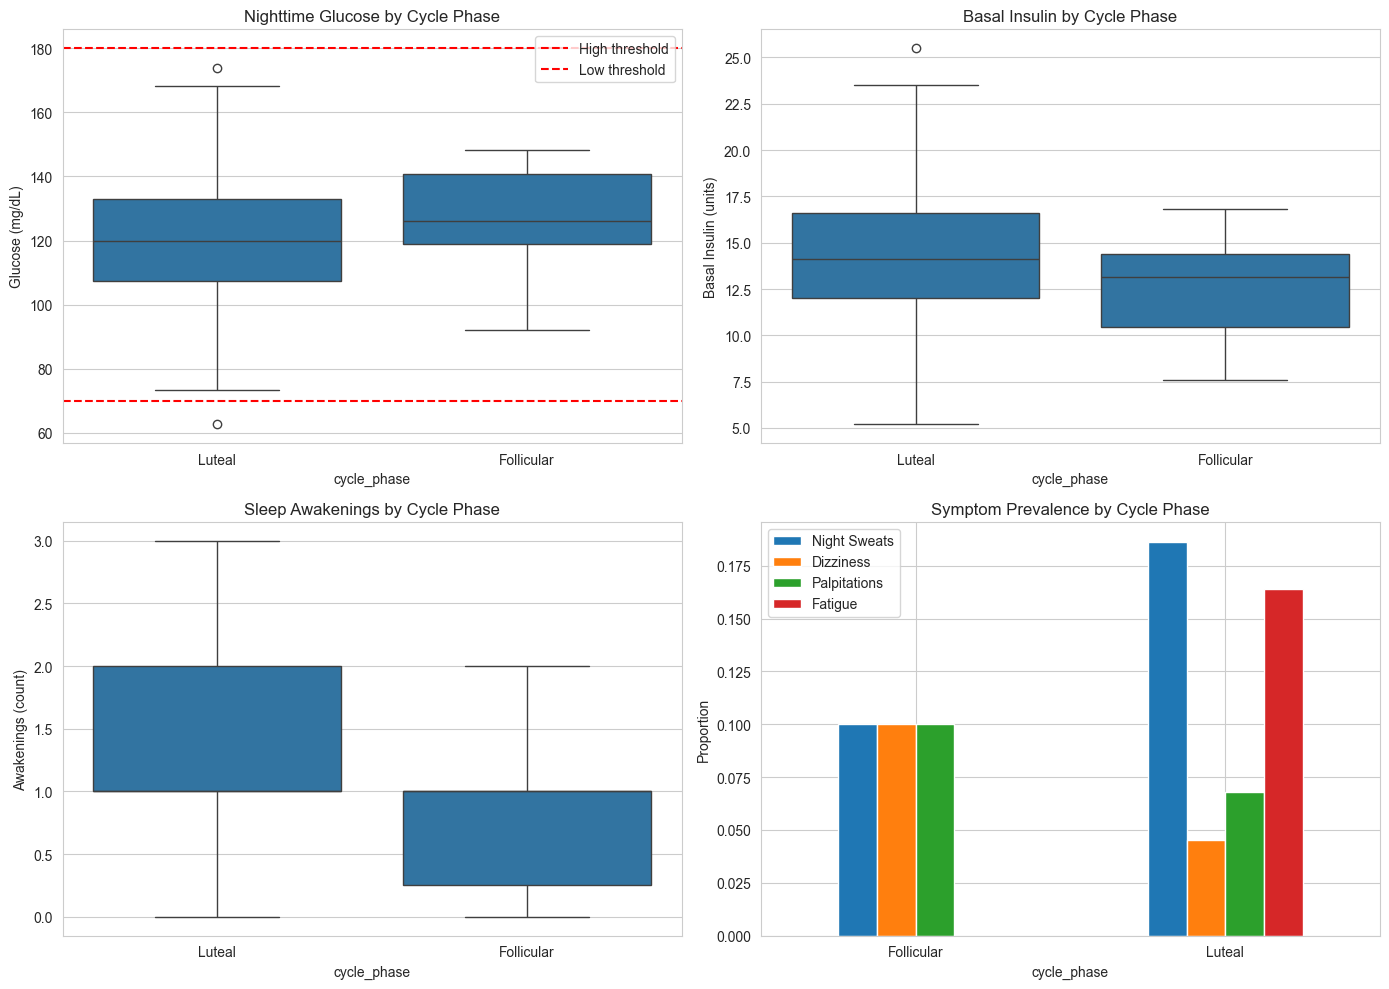

In [7]:
# Create subplots for key metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Nighttime glucose by cycle phase
sns.boxplot(data=df, x='cycle_phase', y='nighttime_glucose', ax=axes[0, 0])
axes[0, 0].set_title('Nighttime Glucose by Cycle Phase')
axes[0, 0].set_ylabel('Glucose (mg/dL)')
axes[0, 0].axhline(y=180, color='r', linestyle='--', label='High threshold')
axes[0, 0].axhline(y=70, color='r', linestyle='--', label='Low threshold')
axes[0, 0].legend()

# Basal insulin by cycle phase
sns.boxplot(data=df, x='cycle_phase', y='basal_insulin', ax=axes[0, 1])
axes[0, 1].set_title('Basal Insulin by Cycle Phase')
axes[0, 1].set_ylabel('Basal Insulin (units)')

# Sleep awakenings by cycle phase
sns.boxplot(data=df, x='cycle_phase', y='sleep_awakenings', ax=axes[1, 0])
axes[1, 0].set_title('Sleep Awakenings by Cycle Phase')
axes[1, 0].set_ylabel('Awakenings (count)')

# Symptom prevalence by cycle phase
symptom_data = df.groupby('cycle_phase')[['has_night_sweats', 'has_dizziness', 'has_palpitations', 'has_fatigue']].mean()
symptom_data.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Symptom Prevalence by Cycle Phase')
axes[1, 1].set_ylabel('Proportion')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)
axes[1, 1].legend(['Night Sweats', 'Dizziness', 'Palpitations', 'Fatigue'])

plt.tight_layout()
plt.show()

## 6. Correlation Analysis

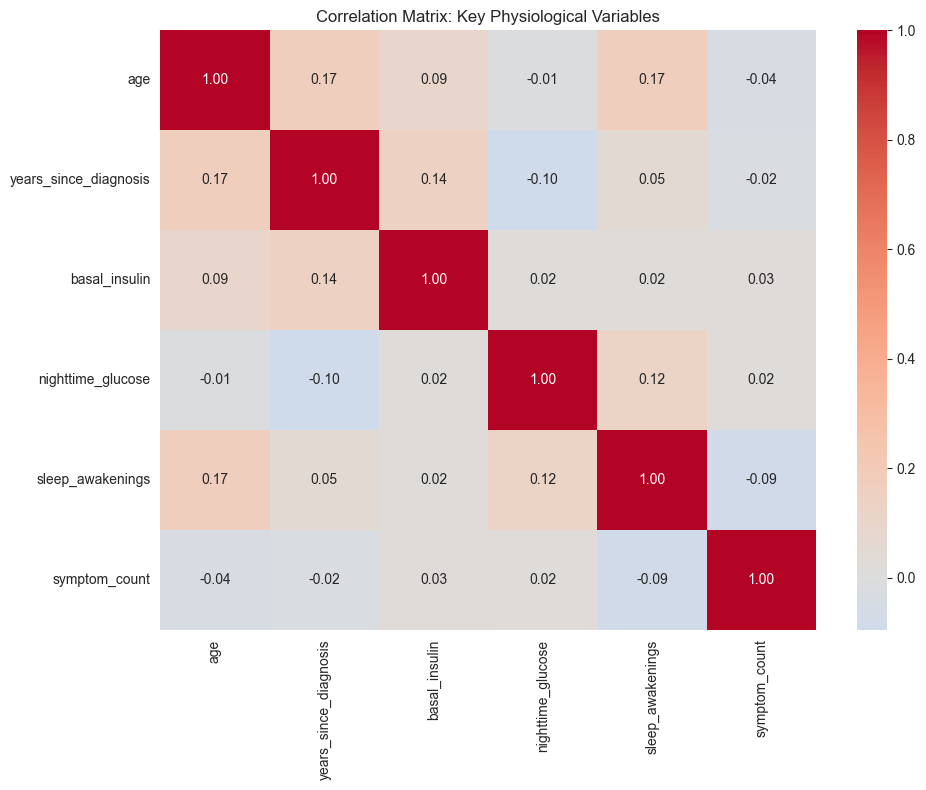

In [8]:
# Select numeric columns for correlation
numeric_cols = ['age', 'years_since_diagnosis', 'basal_insulin', 'nighttime_glucose', 
                'sleep_awakenings', 'symptom_count']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix: Key Physiological Variables')
plt.tight_layout()
plt.show()

## 7. Insulin Delivery Method Analysis

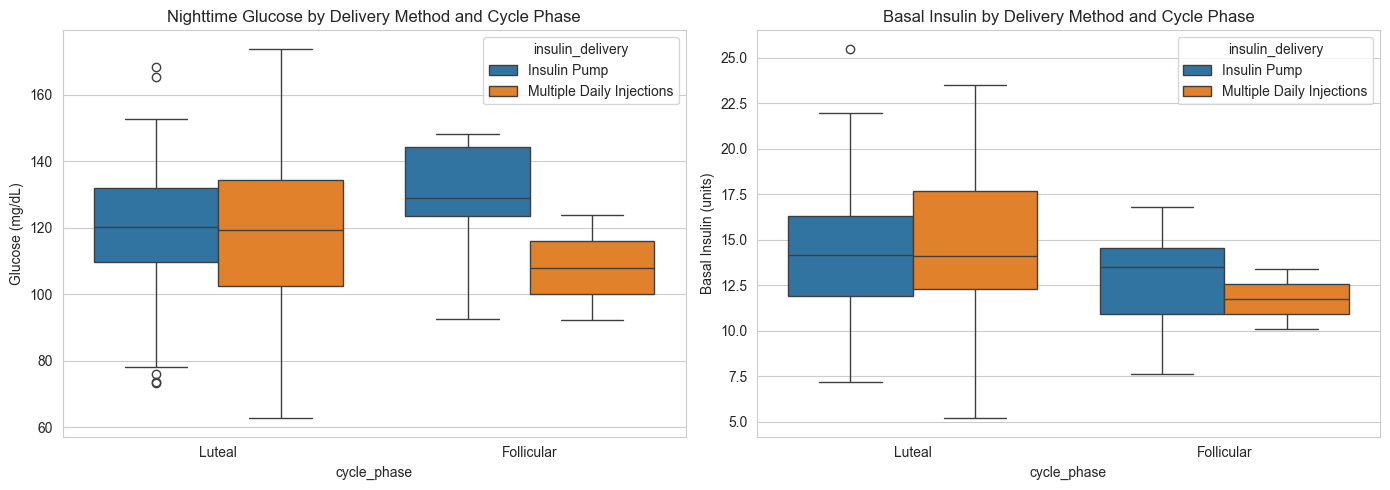

In [9]:
# Compare outcomes by insulin delivery method
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Glucose by delivery method and cycle phase
sns.boxplot(data=df, x='cycle_phase', y='nighttime_glucose', hue='insulin_delivery', ax=axes[0])
axes[0].set_title('Nighttime Glucose by Delivery Method and Cycle Phase')
axes[0].set_ylabel('Glucose (mg/dL)')

# Basal insulin by delivery method and cycle phase
sns.boxplot(data=df, x='cycle_phase', y='basal_insulin', hue='insulin_delivery', ax=axes[1])
axes[1].set_title('Basal Insulin by Delivery Method and Cycle Phase')
axes[1].set_ylabel('Basal Insulin (units)')

plt.tight_layout()
plt.show()

## 8. Exploratory: Patient Narratives

Sample subjective patient responses about glucose stability changes.

In [10]:
# Display sample subjective text responses
print("Sample patient narratives:\n")
for i, text in enumerate(df['subjective_text'].dropna().sample(min(5, len(df))), 1):
    print(f"{i}. {text}\n")

Sample patient narratives:

1. My glucose levels tend to be higher during certain times of the month.

2. My glucose levels tend to be higher during certain times of the month.

3. My glucose levels tend to be higher during certain times of the month.

4. My glucose levels tend to be higher during certain times of the month.

5. My glucose levels tend to be higher during certain times of the month.



## 9. Export Summary Statistics

Generate summary tables for reporting.

In [11]:
# Summary statistics by cycle phase
summary = df.groupby('cycle_phase').agg({
    'nighttime_glucose': ['mean', 'std', 'count'],
    'basal_insulin': ['mean', 'std'],
    'sleep_awakenings': ['mean', 'std'],
    'has_night_sweats': 'mean',
    'has_dizziness': 'mean',
    'has_palpitations': 'mean',
    'has_fatigue': 'mean'
}).round(2)

print("\nSummary Statistics by Cycle Phase:")
display(summary)

# Optional: Save to CSV
# summary.to_csv('output/summary_statistics.csv')
# df.to_csv('output/processed_data.csv', index=False)


Summary Statistics by Cycle Phase:


nighttime_glucose              basal_insulin        \
                         mean    std count          mean   std   
cycle_phase                                                      
Follicular             124.62  19.81    10         12.56  2.75   
Luteal                 119.97  20.35   177         14.20  3.64   

            sleep_awakenings       has_night_sweats has_dizziness  \
                        mean   std             mean          mean   
cycle_phase                                                         
Follicular              0.80  0.63             0.10          0.10   
Luteal                  1.05  0.72             0.19          0.05   

            has_palpitations has_fatigue  
                        mean        mean  
cycle_phase                               
Follicular              0.10        0.00  
Luteal                  0.07        0.16

## 10. Custom Analysis Section

Use the cells below for your own exploratory analysis.

In [ ]:
# Your custom analysis here